In [1]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier as rf
from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.tree import DecisionTreeClassifier as Tree
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from scipy.stats import sem

import sys
sys.path.insert(1, './awp/utils/')

from DataLoader import *
from capacity import *

import warnings
warnings.filterwarnings('ignore')
sns.set()
sns.set_style('whitegrid')
%matplotlib inline

In [14]:
df = load_data(name='compas')
X = df.drop(['is_recid'], axis=1).values
y = df['is_recid'].values

In [15]:
X_full,X_test,y_full,y_test = train_test_split(X,y,test_size=.25,random_state=210)
X_train,X_val,y_train,y_val = train_test_split(X_full,y_full,test_size=.333,random_state=320)

In [16]:
n_models = 1000
n_classes = 2
seeds = np.arange(0,n_models)

acc = np.zeros(n_models)
outputs = np.zeros((n_models, len(y_test), n_classes))
loss = np.zeros((n_models,len(y_test)))
loss_mean = np.zeros(n_models)
loss_sem = np.zeros(n_models)


outputs_val = np.zeros((n_models, len(y_val), n_classes))
loss_val = np.zeros((n_models,len(y_val)))
loss_mean_val = np.zeros(n_models)
loss_sem_val = np.zeros(n_models)

k = 0
for seed in tqdm(seeds):
    #model = rf(random_state=seed,n_jobs=-1)
    model = MLP(hidden_layer_sizes=(50,50),random_state=seed,max_iter=400)
    #model = GBC(random_state=seed)
    model.fit(X_train,y_train)
    acc[k] = model.score(X_test,y_test)
    outputs[k,:,:] = model.predict_proba(X_test)
    
    loss[k,:] = -y_test*np.log(outputs[k,:,0]+1e-15)-(1-y_test)*np.log(outputs[k,:,1]+1e-15)
    
    loss_mean[k] = loss[k,:].mean()
    loss_sem[k] = sem(loss[k,:])
    
    # validatopn
    outputs_val[k,:,:] = model.predict_proba(X_val)
    
    loss_val[k,:] = -y_val*np.log(outputs_val[k,:,0]+1e-15)-(1-y_val)*np.log(outputs_val[k,:,1]+1e-15)
    
    loss_mean_val[k] = loss_val[k,:].mean()
    loss_sem_val[k] = sem(loss[k,:])
    
    k+=1

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [11:45<00:00,  1.42it/s]


In [17]:
print(acc.mean(), acc.std())

0.6734977272727274 0.009750818494758407


In [19]:
epsilon = 0.05
bins = 20
nmodels = 20
initial_model_idx = 1

In [20]:
n_val = y_val.shape[0]
good_models = np.where(loss_mean_val<loss_mean_val.min()+epsilon)
good_outputs = outputs[good_models[0], :, :]

ngood = good_models[0].shape[0]

In [21]:
print(ngood)

163


In [22]:
n_test = y_test.shape[0]
cap_rashomon = compute_capacity(good_outputs)

In [23]:
## true greedy
selected_model = []
selected_model.append(initial_model_idx)
channel_greedy = good_outputs[initial_model_idx, :, :].reshape(1, n_test, 2)


for i in tqdm(range(nmodels)):
    cap_model = np.zeros((ngood-len(selected_model), n_test))
    cnt = 0
    for j in range(ngood):
        
        if j not in selected_model:
            channel = np.vstack((channel_greedy, good_outputs[cnt, :, :].reshape(1, n_test, 2)))
            cap_model[cnt, :] = compute_capacity(channel)
            cnt += 1
        
    cap_max = cap_model.sum(axis=1)
    cap_idx = np.argsort(cap_max)
    
    max_idx = cap_idx[-1]
    
    selected_model.append(max_idx)
    channel_greedy = np.vstack((channel_greedy, good_outputs[max_idx, :, :].reshape(1, n_test, 2)))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [1:50:38<00:00, 331.93s/it]


In [24]:
np.savez_compressed('./compas-resolve-'+str(nmodels)+'.npz', 
                    outputs=outputs,
                    loss_mean_val=loss_mean_val,
                    channel_greedy=channel_greedy,
                    cap_rashomon=cap_rashomon)

In [25]:
cap_greedy = compute_capacity(channel_greedy)

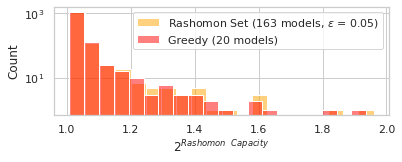

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2))
sns.histplot(2**cap_rashomon, bins=bins, log_scale=(False, True), 
             cumulative=False, stat='count', ax=ax, color='orange', alpha=0.5, label=r'Rashomon Set ({} models, $\epsilon$ = {:.2f})'.format(ngood, epsilon))
sns.histplot(2**cap_greedy, bins=bins, log_scale=(False, True), 
             cumulative=False, stat='count', ax=ax, color='red', alpha=0.5, label='Greedy ({} models)'.format(nmodels))

ax.set_ylabel('Count')
ax.set_xlabel(r'$2^{Rashomon\ \ Capacity}$');
ax.legend(loc='upper right')
# ax.set_xlim(1.1, 2.01)
plt.savefig('compas-resolve-'+str(nmodels)+'.png', format='png', dpi=300, bbox_inches='tight')